# bikeの特徴量の解釈
https://christophm.github.io/interpretable-ml-book/limo.html

## データの意味

- cnt:casualとregisteredのユーザーの数。回帰のターゲット
- season:spring, summer, fall or winter.
- holiday
- year: 2011 or 2012.
- dateday:2011/01/01からの日数。この特料量は時間経過によるトレンドを導くのに使用する。
- working day or weekend.
- 天気:
    - 1 clear, few clouds, partly cloudy, cloudy
    - 2 mist + clouds, mist + broken clouds, mist + few clouds, mist
    - 3 light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    - 4 heavy rain + ice pallets + thunderstorm + mist, snow + mist
- temp：Temperature in degrees Celsius.41で割り、正規化されている。
- atemp：体感温度。50で割り、正規化されている。
- hum:湿度(0 to 100). 100で割り正規化されている。
- Wind speed: km/hour.　67で割り、正規化されている。

In [32]:
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns;sns.set()
%matplotlib inline
os.getcwd()

'C:\\home\\myproj\\interpretable-machine-learning\\LinearRegression\\FeatureImportance'

In [33]:
data_dir = '../../data/bike'
day_file = 'day.csv'
hour_file = 'hour.csv'

In [34]:
df_day = pd.read_csv(os.path.join(data_dir, day_file))
# headにすることで先頭だけ確認できる。
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [35]:
# ここからデータを整形していく
# 目的変数をYに
Y = df_day['cnt']

#　dteday をなくしt、instantをdayに（本当は日付を経過日数に変換しないと駄目）
del df_day['dteday']
del df_day['yr']

df_day = df_day.rename(columns={'instant': 'days'})

# onehot(季節)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.season.values.reshape(1, -1).transpose())
df_season = pd.DataFrame(index=df_day.season.index, columns=['season-SPRING', 'season-SUMMER', 'season-FALL', "season-WINTER"], data=enced.toarray())
df_day = pd.concat([df_day, df_season], axis=1)
del df_day['season']

# onehot(天気)
encoder = OneHotEncoder()
enced = encoder.fit_transform(df_day.weathersit.values.reshape(1, -1).transpose())
df_weather = pd.DataFrame(index=df_day.weathersit.index, columns=['weather-CLEAR', 'weather-MYST', 'weather-SNOW'], data=enced.toarray())
df_day = pd.concat([df_day, df_weather], axis=1)
del df_day['weathersit']

# 正規化を戻す
df_day['temp'] = df_day['temp'] *  (39 - (-8)) + (-8)
df_day['hum'] = df_day['hum'] * 100
df_day['windspeed'] = df_day['windspeed'] * 67

# 未使用の特徴量を削除
del df_day['casual']
del df_day['registered']
del df_day['cnt']
del df_day['mnth']
del df_day['weekday']
del df_day['atemp']

df_day.head()

,days,holiday,workingday,temp,hum,windspeed,season-SPRING,season-SUMMER,season-FALL,season-WINTER,weather-CLEAR,weather-MYST,weather-SNOW
0,1,0,0,8.175849,80.5833,10.749882,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,0,9.083466,69.6087,16.652113,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0,1,1.229108,43.7273,16.636703,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,0,1,1.400000,59.0435,10.739832,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,1,2.666979,43.6957,12.522300,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [36]:
df_day.head()

,days,holiday,workingday,temp,hum,windspeed,season-SPRING,season-SUMMER,season-FALL,season-WINTER,weather-CLEAR,weather-MYST,weather-SNOW
0,1,0,0,8.175849,80.5833,10.749882,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,0,9.083466,69.6087,16.652113,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,0,1,1.229108,43.7273,16.636703,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,0,1,1.400000,59.0435,10.739832,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0,1,2.666979,43.6957,12.522300,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
# モデルの作成と学習

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df_day, Y)

# 標準偏差
pred = model.predict(df_day)
num = df_day.shape[0]
sigma = np.sqrt(np.sum(np.square(Y - pred))) / (num - 1)

# 標準偏差から標準誤差
se = sigma / np.sqrt(num)

print("標準偏差 :", sigma)
print("標準誤差 :", se)

標準偏差 : 32.57785109962483
標準誤差 : 1.2049353492992356


In [38]:
#print("weight: ", model.coef_)
print("%16s: %16f" % ("inteception", model.intercept_))
# 名前と正規化
parms = ['days', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 
         'season-SPRING', 'season-SUMMER',  'season-FALL',  'season-WINTER',
         'weather-CLEAR', 'weather-MYST',  'weather-SNOW'
]



for name, weight in zip(parms, model.coef_):
    print("%16s: %16f " % (name, weight))



     inteception:      1999.987074
            days:         4.926432 
         holiday:      -686.115442 
      workingday:       124.920938 
            temp:       110.709582 
             hum:       -17.377199 
       windspeed:       -42.513472 
   season-SPRING:      -365.784110 
   season-SUMMER:       533.534046 
     season-FALL:      -227.568678 
   season-WINTER:        59.818742 
   weather-CLEAR:       760.312815 
    weather-MYST:       380.914285 
    weather-SNOW:     -1141.227100 


In [45]:
# PDPをやってみたが全く意味が無かった
x_pdp = []
y_pdp = []

t_start = int(min(df_day['temp']))
t_end = int(max(df_day['temp']))

temp_save = df_day['temp'].copy(deep=True)


In [47]:
for t in range(t_start, t_end):
    df_day['temp'] = t
    y = model.predict(df_day).sum() / num
    x_pdp.append(t)
    y_pdp.append(y)
    
df_day['temp'] = temp_save

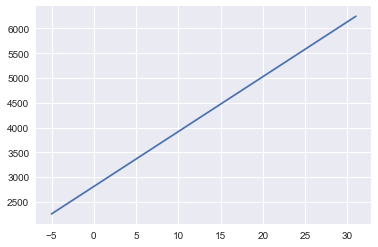

In [49]:
plt.plot(x_pdp, y_pdp)
plt.show()